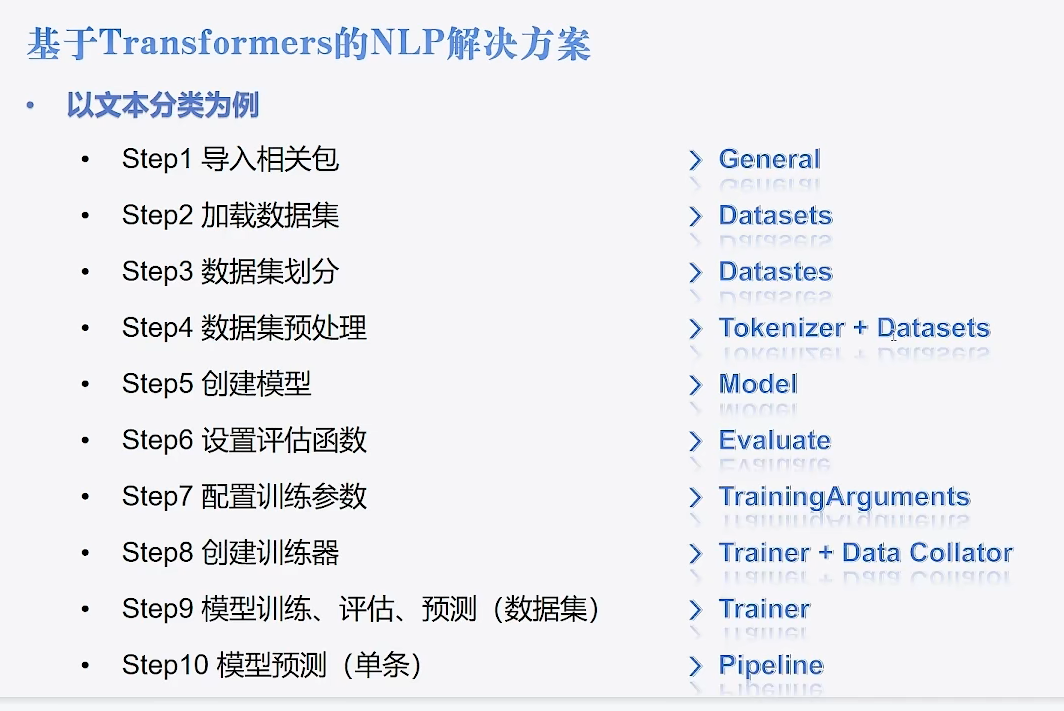

# 文本分类实例

## Step1 导入相关包

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch

/data1/zhengnanyan/miniconda3/envs/LLMpython39/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Step2 加载数据集

In [2]:
dataset = load_dataset("csv", data_files="./ChnSentiCorp_htl_all.csv", split="train")
dataset = dataset.filter(lambda x: x["review"] is not None)
dataset

Dataset({
    features: ['label', 'review'],
    num_rows: 7765
})

## Step3 划分数据集

In [3]:
datasets = dataset.train_test_split(test_size=0.1)
datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'review'],
        num_rows: 6988
    })
    test: Dataset({
        features: ['label', 'review'],
        num_rows: 777
    })
})

## Step4 数据集预处理

In [4]:
import torch

tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-macbert-large")

def process_function(examples):
    tokenized_examples = tokenizer(examples["review"], max_length=32, truncation=True, padding="max_length")
    tokenized_examples["labels"] = examples["label"] # 添加新列
    return tokenized_examples

tokenized_datasets = datasets.map(process_function, batched=True, remove_columns=datasets["train"].column_names)
tokenized_datasets

tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/6988 [00:00<?, ? examples/s]

Map:   0%|          | 0/777 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 6988
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 777
    })
})

## Step5 创建模型

In [5]:
model = AutoModelForSequenceClassification.from_pretrained("hfl/chinese-macbert-large")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at hfl/chinese-macbert-large and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Step6 创建评估函数

In [10]:
import evaluate

# 如果网络不太好，也可以使用本地加载的方式
acc_metric = evaluate.load("./metric_accuracy.py")
f1_metirc = evaluate.load("./metric_f1.py")

In [11]:
def eval_metric(eval_predict):
    predictions, labels = eval_predict
    predictions = predictions.argmax(axis=-1)
    acc = acc_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metirc.compute(predictions=predictions, references=labels)
    acc.update(f1)
    return acc

## Step7 创建TrainingArguments

In [2]:
train_args1 = TrainingArguments(output_dir="./checkpoints",      # 输出文件夹
                               per_device_eval_batch_size=1,    # 验证时的batch_size
                               num_train_epochs=1,              # 训练轮数
                               logging_steps=10,                # log 打印的频率
                               evaluation_strategy="epoch",     # 评估策略
                               save_strategy="epoch",           # 保存策略
                               save_total_limit=3,              # 最大保存数
                               learning_rate=2e-5,              # 学习率
                               weight_decay=0.01,               # weight_decay
                               metric_for_best_model="f1",      # 设定评估指标
                               load_best_model_at_end=True)     # 训练完成后加载最优模型
train_args1

TrainingArguments(
_n_gpu=8,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_

In [12]:
train_args = TrainingArguments(output_dir="./checkpoints",      # 输出文件夹
                               per_device_train_batch_size=1,   # 训练时的batch_size
                               gradient_accumulation_steps=32,  # *** 梯度累加 ***
                               gradient_checkpointing=True,     # *** 梯度检查点 ***
                               optim="adafactor",               # *** adafactor优化器 *** 
                               per_device_eval_batch_size=1,    # 验证时的batch_size
                               num_train_epochs=1,              # 训练轮数
                               logging_steps=10,                # log 打印的频率
                               evaluation_strategy="epoch",     # 评估策略
                               save_strategy="epoch",           # 保存策略
                               save_total_limit=3,              # 最大保存数
                               learning_rate=2e-5,              # 学习率
                               weight_decay=0.01,               # weight_decay
                               metric_for_best_model="f1",      # 设定评估指标
                               load_best_model_at_end=True)     # 训练完成后加载最优模型
train_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=32,
gradient_checkpointing=True,
gradient_checkpointing_kwargs=None,
greater_is_better=True,
group_by_

降低显存使用率:（会增加训练时间）

1. 减小per_device_train_batch_size

2. 增加gradient_accumulation_steps

3. gradient_checkpointing=True

4. optim指定不同的优化器，例如“adafactor”

5. 参数冻结：(只训练全连接层的参数，把bert部分的参数全部冻结)（减少训练时间）
    ```
    for name, param in model.bert.named_parameters():
        param.requires_grad = False
    ```

6. 数据预处理：减少max_length(减少训练时间)
    

## Step8 创建Trainer

有trainer就不需要DataLoader

In [13]:
from transformers import DataCollatorWithPadding

# *** 参数冻结 *** 
for name, param in model.bert.named_parameters():
    param.requires_grad = False

trainer = Trainer(model=model, 
                  args=train_args, 
                  train_dataset=tokenized_datasets["train"], 
                  eval_dataset=tokenized_datasets["test"], 
                  data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
                  compute_metrics=eval_metric)

## Step9 模型训练

In [14]:
trainer.train()

  0%|          | 0/218 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
c:\Users\yuyao\miniconda3\envs\transformers\lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'loss': 0.6656, 'learning_rate': 1.9082568807339454e-05, 'epoch': 0.05}
{'loss': 0.6525, 'learning_rate': 1.81651376146789e-05, 'epoch': 0.09}
{'loss': 0.6477, 'learning_rate': 1.724770642201835e-05, 'epoch': 0.14}
{'loss': 0.6265, 'learning_rate': 1.63302752293578e-05, 'epoch': 0.18}
{'loss': 0.6301, 'learning_rate': 1.541284403669725e-05, 'epoch': 0.23}
{'loss': 0.6525, 'learning_rate': 1.4495412844036698e-05, 'epoch': 0.27}
{'loss': 0.654, 'learning_rate': 1.3577981651376149e-05, 'epoch': 0.32}
{'loss': 0.6258, 'learning_rate': 1.2660550458715597e-05, 'epoch': 0.37}
{'loss': 0.6317, 'learning_rate': 1.1743119266055047e-05, 'epoch': 0.41}
{'loss': 0.6386, 'learning_rate': 1.0825688073394496e-05, 'epoch': 0.46}
{'loss': 0.6189, 'learning_rate': 9.908256880733946e-06, 'epoch': 0.5}
{'loss': 0.6208, 'learning_rate': 8.990825688073395e-06, 'epoch': 0.55}
{'loss': 0.6143, 'learning_rate': 8.073394495412845e-06, 'epoch': 0.6}
{'loss': 0.6304, 'learning_rate': 7.155963302752295e-06, 'epoch

  0%|          | 0/777 [00:00<?, ?it/s]

{'eval_loss': 0.6191020011901855, 'eval_accuracy': 0.6924066924066924, 'eval_f1': 0.8182509505703421, 'eval_runtime': 10.8256, 'eval_samples_per_second': 71.774, 'eval_steps_per_second': 71.774, 'epoch': 1.0}
{'train_runtime': 143.9298, 'train_samples_per_second': 48.551, 'train_steps_per_second': 1.515, 'train_loss': 0.6344035021755674, 'epoch': 1.0}


TrainOutput(global_step=218, training_loss=0.6344035021755674, metrics={'train_runtime': 143.9298, 'train_samples_per_second': 48.551, 'train_steps_per_second': 1.515, 'train_loss': 0.6344035021755674, 'epoch': 1.0})

In [15]:
trainer.evaluate(tokenized_datasets["test"])

  0%|          | 0/777 [00:00<?, ?it/s]

{'eval_loss': 0.6191020011901855,
 'eval_accuracy': 0.6924066924066924,
 'eval_f1': 0.8182509505703421,
 'eval_runtime': 10.615,
 'eval_samples_per_second': 73.198,
 'eval_steps_per_second': 73.198,
 'epoch': 1.0}

In [16]:
trainer.predict(tokenized_datasets["test"])

  0%|          | 0/777 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[-0.72761387, -0.07979526],
       [-0.77411073,  0.03051195],
       [-0.7125532 ,  0.02187884],
       ...,
       [-0.69379896, -0.02149625],
       [-0.6627295 ,  0.03299953],
       [-0.6437226 , -0.04126655]], dtype=float32), label_ids=array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1

## Step10 模型预测

In [4]:
tokenizer = AutoTokenizer.from_pretrained("hfl/chinese-macbert-large")

V.cuda()的区别

In [13]:
sen = "我觉得这家酒店不错，饭很好吃！"
id2_label = {0: "差评！", 1: "好评！"}

with torch.inference_mode():
    inputs = tokenizer(sen, return_tensors="pt")
for k,v in inputs.items():
    print(k,':',v)

print("inputs type:",type(inputs))

inputs1 = {k:v for k,v in inputs.items()}
print("inputs1 type:",type(inputs1))
print(inputs1)

inputs2 = {k:v.cuda() for k,v in inputs.items()}
print("inputs2 type:",type(inputs2))
print(inputs2)

input_ids : tensor([[ 101, 2769, 6230, 2533, 6821, 2157, 6983, 2421,  679, 7231, 8024, 7649,
         2523, 1962, 1391, 8013,  102]])
token_type_ids : tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask : tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
inputs type: <class 'transformers.tokenization_utils_base.BatchEncoding'>
inputs1 type: <class 'dict'>
{'input_ids': tensor([[ 101, 2769, 6230, 2533, 6821, 2157, 6983, 2421,  679, 7231, 8024, 7649,
         2523, 1962, 1391, 8013,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
inputs2 type: <class 'dict'>
{'input_ids': tensor([[ 101, 2769, 6230, 2533, 6821, 2157, 6983, 2421,  679, 7231, 8024, 7649,
         2523, 1962, 1391, 8013,  102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor(

In [17]:
sen = "我觉得这家酒店不错，饭很好吃！"
id2_label = {0: "差评！", 1: "好评！"}
model.eval()
with torch.inference_mode():
    inputs = tokenizer(sen, return_tensors="pt")
    inputs = {k: v.cuda() for k, v in inputs.items()}
    logits = model(**inputs).logits
    pred = torch.argmax(logits, dim=-1)
    print(f"输入：{sen}\n模型预测结果:{id2_label.get(pred.item())}")

输入：我觉得这家酒店不错，饭很好吃！
模型预测结果:好评！


In [18]:
from transformers import pipeline

model.config.id2label = id2_label
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

In [19]:
pipe(sen)

[{'label': '好评！', 'score': 0.672111451625824}]